# Pairs Trading Strategy applied to S&P 500

## 1. Libraries Import

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import warnings
warnings.filterwarnings("ignore")

## 2. Dataset import, check, and Split

In [19]:
SPX = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = SPX.Symbol.tolist()

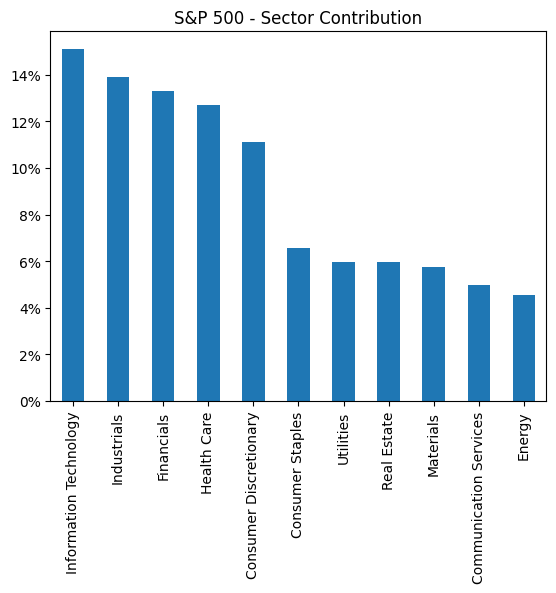

In [39]:
SPX['GICS Sector'].value_counts(normalize=True).plot(kind='bar', title='S&P 500 - Sector Contribution')
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]); 

In [20]:
dataset = yf.download(tickers, start="2021-01-01", end="2021-12-31")

[*********************100%***********************]  503 of 503 completed

4 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- GEHC: Data doesn't exist for startDate = 1609477200, endDate = 1640926800
- CEG: Data doesn't exist for startDate = 1609477200, endDate = 1640926800
- BRK.B: No data found for this date range, symbol may be delisted


In [43]:
dataset.isnull().sum().sort_values(ascending=False).head(40)

Open       BF.B     251
           GEHC     251
Volume     CEG      251
           GEHC     251
Low        CEG      251
High       CEG      251
           BF.B     251
           GEHC     251
Low        BF.B     251
Close      CEG      251
Volume     BRK.B    251
Adj Close  BRK.B    251
High       BRK.B    251
Adj Close  BF.B     251
Close      GEHC     251
Low        BRK.B    251
Adj Close  CEG      251
Open       CEG      251
Volume     BF.B     251
Close      BRK.B    251
Adj Close  GEHC     251
Low        GEHC     251
Open       BRK.B    251
Close      BF.B     251
Open       OGN       91
Volume     OGN       91
Low        OGN       91
High       OGN       91
Adj Close  OGN       91
Close      OGN       91
Low        WTW        0
Open       ACGL       0
           ACN        0
Low        XRAY       0
           WY         0
           WMT        0
Open       ADBE       0
           ADI        0
           ADM        0
           ADP        0
dtype: int64

In [44]:
dataset.dropna(axis=1, inplace=True)

In [45]:
dataset.isnull().sum().sort_values(ascending=False)

Adj Close  A       0
Open       AAPL    0
Low        XYL     0
           YUM     0
           ZBH     0
                  ..
High       AAP     0
           AAPL    0
           ABBV    0
           ABC     0
Volume     ZTS     0
Length: 2988, dtype: int64

In [46]:
split = round(9/12 * len(dataset))
dataset_train, dataset_test = dataset.iloc[:split], dataset.iloc[split:]

## 3. Sector Selection

In [47]:
SPX['GICS Sector'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Communication Services', 'Consumer Staples',
       'Consumer Discretionary', 'Utilities', 'Financials', 'Materials',
       'Real Estate', 'Energy'], dtype=object)

In [48]:
sector = 'Industrials'
tickers = SPX[SPX['GICS Sector'] == sector].Symbol.tolist()

## 4. Pair selection

#### 4.1 Functions Definition

In [49]:
def check_for_cointegration(dataset, cutoff = 0.05):
    
    """
    Effettua il test di cointegrazione su tutte le coppie e le sue rispettive perumtazioni riportando una lista con i p-values
    """
    n = dataset.shape[1]
    keys = dataset.keys()
    scores = []
    
    for i in range(n):
        for j in range(n):
            
            if i != j:
                S1 = dataset[keys[i]]
                S2 = dataset[keys[j]]
                
                dic = { f'{dataset[keys[i]].name} {dataset[keys[j]].name}': coint(S1, S2),
                        f'{dataset[keys[j]].name} {dataset[keys[i]].name}': coint(S2, S1)}
                
                pair = min(dic, key=dic.get)
                pvalue = dic[pair][1]
                Pair1 = pair.split(' ')[0]
                Pair2 = pair.split(' ')[1]
                
                if pvalue < cutoff:
                    scores.append({'Ticker_1': Pair1, 'Ticker_2': Pair2, 'Coint': pvalue })
                    
    scores = pd.DataFrame(scores).drop_duplicates().reset_index(drop=True)
    
    return scores            

In [50]:
# sostituito con versione sintetica con solo p-value nella F pair_selection_statistics

def check_for_stationarity(spread, cutoff=0.01):
    
    """
    Performa ADF test per verificare la stazionarieta' dello spread delle coppia identificata come cointegrata
    """

    pvalue = adfuller(spread)[1]
    
    if pvalue < cutoff:
        print(f'p-value = {pvalue.round(5)}. The spread is likely STATIONARY with a {cutoff} significance level')
    else:
        print(f'p-value = {pvalue.round(5)}. The spread is likely NON-STATIONARY with a {cutoff} significance level')

In [51]:
####################################
# Calculates the generalized Hurst exponent H(q) from the scaling 
# of the renormalized q-moments of the distribution 
#
#       <|x(t+r)-x(t)|^q>/<x(t)^q> ~ r^[qH(q)]
#
####################################
# H = genhurst(S,q)
# S is 1xT data series (T>50 recommended)
# calculates H, specifies the exponent q
#
# example:
#   generalized Hurst exponent for a random vector
#   H=genhurst(np.random.rand(10000,1),3)
#
####################################
# for the generalized Hurst exponent method please refer to:
#
#   T. Di Matteo et al. Physica A 324 (2003) 183-188 
#   T. Di Matteo et al. Journal of Banking & Finance 29 (2005) 827-851
#   T. Di Matteo Quantitative Finance, 7 (2007) 21-36
#
####################################
##   written in Matlab : Tomaso Aste, 30/01/2013 ##
##   translated to Python (3.6) : Peter Rupprecht, p.t.r.rupprecht (AT) gmail.com, 25/05/2017 ##

import warnings
 
def genhurst(S,q):
    
    S = np.array(S)
    L=len(S)       
    if L < 100:
        warnings.warn('Data series very short!')
       
    H = np.zeros((len(range(5,20)),1))
    k = 0
    
    for Tmax in range(5,20):
        
        x = np.arange(1,Tmax+1,1)
        mcord = np.zeros((Tmax,1))
        
        for tt in range(1,Tmax+1):
            dV = S[np.arange(tt,L,tt)] - S[np.arange(tt,L,tt)-tt] 
            VV = S[np.arange(tt,L+tt,tt)-tt]
            N = len(dV) + 1
            X = np.arange(1,N+1,dtype=np.float64)
            Y = VV
            mx = np.sum(X)/N
            SSxx = np.sum(X**2) - N*mx**2
            my = np.sum(Y)/N
            SSxy = np.sum( np.multiply(X,Y))  - N*mx*my
            cc1 = SSxy/SSxx
            cc2 = my - cc1*mx
            ddVd = dV - cc1
            VVVd = VV - np.multiply(cc1,np.arange(1,N+1,dtype=np.float64)) - cc2
            mcord[tt-1] = np.mean( np.abs(ddVd)**q )/np.mean( np.abs(VVVd)**q )
            
        mx = np.mean(np.log10(x))
        SSxx = np.sum( np.log10(x)**2) - Tmax*mx**2
        my = np.mean(np.log10(mcord))
        SSxy = np.sum( np.multiply(np.log10(x),np.transpose(np.log10(mcord)))) - Tmax*mx*my
        H[k] = SSxy/SSxx
        k = k + 1
        
    mH = np.mean(H)/q
    
    return mH

In [52]:
def get_halflife(spread):
    
    s_lag = spread.shift(1).dropna()
    s_ret = (spread - s_lag).dropna()
    s_lag2 = sm.add_constant(s_lag)

    model = sm.OLS(s_ret,s_lag2)
    res = model.fit()

    halflife = - np.log(2) / np.log(1 + res.params[0])
    
    return halflife

In [53]:
def zero_crossings(spread):
    return ((spread[1:].values * spread[:-1].values) < 0).sum()

In [55]:
def pair_selection_statistics(dataset, coint_cutoff, hurst_q = 30, hurst_cutoff = None ,adf_cutoff = None, hl_cutoff = None, zc_cutoff = None):
    
    # check cointegration
    df = check_for_cointegration(dataset=dataset, cutoff=coint_cutoff)
    
    #check stationarity
    df['ADF'] = ''
    df['Correlation'] = ''
    df['Hedge_Ratio'] = ''
    df['Hurst'] = ''
    df['Half_Life'] =''
    df['Zero_Crossings'] = ''
    for index, row in df.iterrows():
        df.Hedge_Ratio.iloc[index] = hedge_ratio = sm.OLS(dataset[df.Ticker_1.iloc[index]],dataset[df.Ticker_2.iloc[index]]).fit().params[0]
        spread = dataset[df.Ticker_1.iloc[index]] - hedge_ratio * dataset[df.Ticker_2.iloc[index]]
        df.ADF.iloc[index] = adfuller(spread)[1].round(5)
        df.Correlation.iloc[index] = np.corrcoef(dataset[df.Ticker_1.iloc[index]].pct_change().dropna(),dataset[df.Ticker_2.iloc[index]].pct_change().dropna())[0][1].round(5)
        df.Hurst.iloc[index] = genhurst(spread, q = hurst_q).round(5)
        df.Half_Life.iloc[index] = get_halflife(spread).round(5)
        df.Zero_Crossings.iloc[index] = zero_crossings(spread)
    
    if adf_cutoff is not None:
        df = df[df.ADF <= adf_cutoff]

    if hurst_cutoff is not None:
        df = df[df.Hurst <= hurst_cutoff]
        
    if hl_cutoff is not None:
        df = df[df.Half_Life <= hl_cutoff]
        
    if zc_cutoff is not None:
        df = df[df.Zero_Crossings <= zc_cutoff]
    
    return df.reset_index(drop=True)

#### 4.2 Pairs Selection

In [56]:
pair_selection = pair_selection_statistics(dataset_train.Close[tickers], coint_cutoff=0.05, hurst_q=20, hurst_cutoff=None, adf_cutoff=0.05, hl_cutoff=None, zc_cutoff=None)

In [64]:
pair_selection.sort_values('Coint',ascending=True).head(10)

,Ticker_1,Ticker_2,Coint,ADF,Correlation,Hedge_Ratio,Hurst,Half_Life,Zero_Crossings
9,ALK,LUV,0.000444,0.0004,0.84859,1.131517,0.26308,3.5174,31
69,WAB,VRSK,0.001363,0.0001,0.13306,0.441373,0.24923,4.68817,32
14,GE,BA,0.001553,0.00152,0.50354,0.348911,0.24671,6.03388,27
58,SWK,LMT,0.006366,0.00356,0.34434,0.536073,0.24236,5.08152,26
50,URI,IR,0.006394,0.02099,0.67945,6.45244,0.31959,9.3818,25
64,PNR,RSG,0.007409,0.00143,0.43288,0.618087,0.3805,5.11992,30
21,ROK,CTAS,0.008328,0.0322,0.46751,0.768009,0.37353,7.78112,21
46,IEX,HON,0.008433,0.00314,0.60314,0.975543,0.3082,4.76048,30
54,JCI,OTIS,0.008941,0.01041,0.45238,0.83106,0.2145,8.64421,24
33,EMR,LHX,0.009228,0.04529,0.49409,0.443327,0.2558,7.35203,24


## 5. Pairs Visualization

In [65]:
pair = ['ALK','LUV']

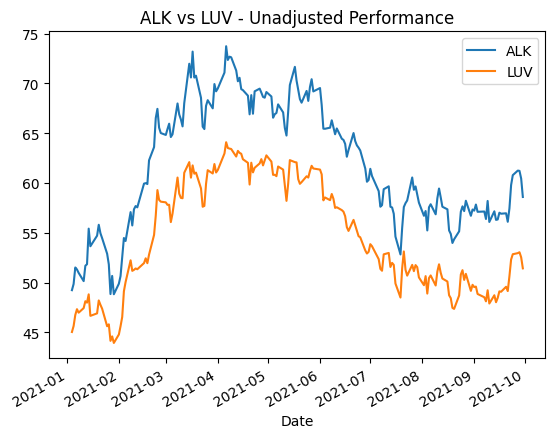

In [67]:
dataset_train.Close[pair].plot(title=(f'{pair[0]} vs {pair[1]} - Unadjusted Performance'));

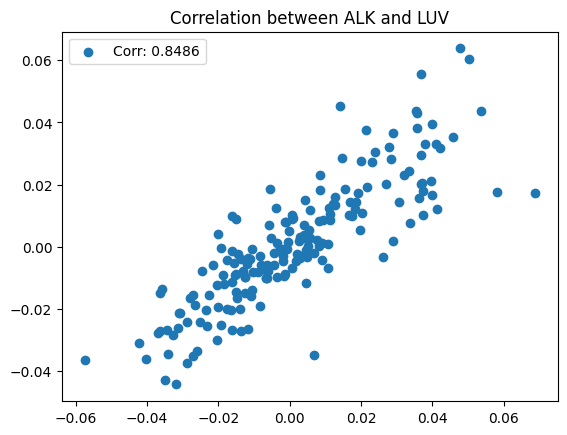

In [68]:
plt.scatter(dataset_train.Close[pair[0]].pct_change(),dataset_train.Close[pair[1]].pct_change(), \
            label = f'Corr: {dataset_train.Close[pair].pct_change().corr().iloc[0][1].round(4)}')
plt.title(f'Correlation between {pair[0]} and {pair[1]}')
plt.legend();

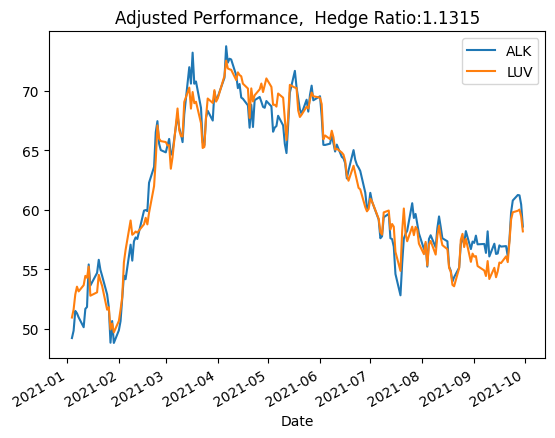

In [69]:
model = sm.OLS(dataset_train.Close[pair[0]],dataset_train.Close[pair[1]])
hedge_ratio = model.fit().params[0]
dataset_train.Close[pair[0]].plot()
(hedge_ratio * dataset_train.Close[pair[1]]).plot()
plt.title(f'Adjusted Performance,  Hedge Ratio:{hedge_ratio.round(4)}')
plt.legend();

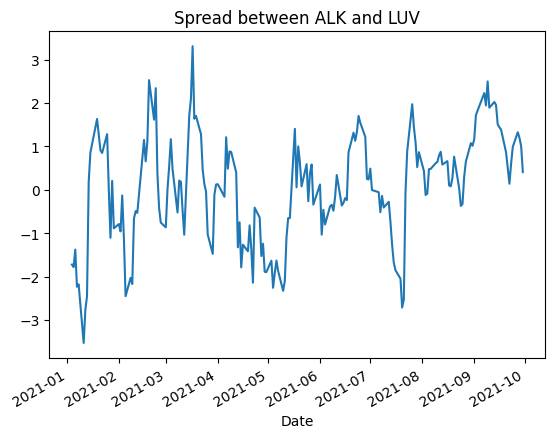

In [70]:
spread = dataset_train.Close[pair[0]] - hedge_ratio * dataset_train.Close[pair[1]]
spread.plot(title=f'Spread between {pair[0]} and {pair[1]}');

## 6. Formation Period

In [74]:
def formation_period(pairs_dataset, train_test_split):
    
    """
    Da usarsi in fase di backtest per la separazione del dataset in train e test e per il calcolo dei parametri sul train
    """
    
    split = round(train_test_split * len(pairs_dataset))
    pairs_dataset_train, pairs_dataset_test = pairs_dataset.iloc[:split], pairs_dataset.iloc[split:]
    hedge_ratio = sm.OLS(pairs_dataset_train.iloc[:,1],pairs_dataset_train.iloc[:,3]).fit().params[0]
    spread = pairs_dataset_train.iloc[:,1] - hedge_ratio * pairs_dataset_train.iloc[:,3]
    z_score = (spread - spread.mean()) / spread.std()
    pairs_dataset_train[['Z_Score','Hedge_Ratio']] = z_score, hedge_ratio
    return pairs_dataset_train, pairs_dataset_test

In [72]:
pairs_dataset = pd.DataFrame(index=dataset.index)
pairs_dataset[f'{pair[0]}_open'] = dataset.Open[pair[0]] 
pairs_dataset[f'{pair[0]}_close'] = dataset.Close[pair[0]]
pairs_dataset[f'{pair[1]}_open'] = dataset.Open[pair[1]] 
pairs_dataset[f'{pair[1]}_close'] = dataset.Close[pair[1]]
pairs_dataset.head()

,ALK_open,ALK_close,LUV_open,LUV_close
Date,,,,
2021-01-04 00:00:00,52.169998,49.240002,46.480000,45.040001
2021-01-05 00:00:00,48.840000,49.860001,44.900002,45.639999
2021-01-06 00:00:00,49.849998,51.520000,45.500000,46.750000
2021-01-07 00:00:00,51.720001,51.320000,46.750000,47.330002
2021-01-08 00:00:00,51.790001,50.980000,47.639999,46.980000


In [75]:
train_df, test_df = formation_period(pairs_dataset,9/12)

In [81]:
train_df.tail(1)

,ALK_open,ALK_close,LUV_open,LUV_close,Z_Score,Hedge_Ratio
Date,,,,,,
2021-09-30 00:00:00,60.18,58.599998,52.200001,51.43,0.311107,1.131517


## 7. Trading Period

In [82]:
def trading_period(pairs_dataset_train, pairs_dataset_test, rolling_window=None):
    
    full_pairs_dataset = pairs_dataset_train.append(pairs_dataset_test).fillna(0)
    
    if rolling_window is not None:
        
        rolling = 0
        for i in range(len(pairs_dataset_train),len(full_pairs_dataset)):
            roll_df =  full_pairs_dataset.iloc[(len(train_df) + rolling) - rolling_window : (len(train_df) + 1 + rolling)]
            hedge_ratio = sm.OLS(roll_df.iloc[:,1],roll_df.iloc[:,3]).fit().params[0]
            spread = roll_df.iloc[:,1] - hedge_ratio * roll_df.iloc[:,3]
            z_score = (spread - spread.mean()) / spread.std()
            full_pairs_dataset.iloc[i][['Z_Score','Hedge_Ratio']] = z_score.iloc[-1], hedge_ratio

            rolling += 1
    
    else:       
    
        for i in range(len(pairs_dataset_train),len(full_pairs_dataset)):
                hedge_ratio = sm.OLS(full_pairs_dataset.iloc[:i+1,1],full_pairs_dataset.iloc[:i+1,3]).fit().params[0]
                spread = full_pairs_dataset.iloc[:i+1,1] - hedge_ratio * full_pairs_dataset.iloc[:i+1,3]
                z_score = (spread - spread.mean()) / spread.std()
                full_pairs_dataset.iloc[i][['Z_Score','Hedge_Ratio']] = z_score.iloc[-1], hedge_ratio
        
    pairs_dataset_test = full_pairs_dataset.iloc[len(pairs_dataset_train):]
    return pairs_dataset_test

#### 7.1 Trading Period - No Rolling Window

In [125]:
test_df = trading_period(train_df,test_df,rolling_window=None)

In [126]:
entry_point = 2
stop_loss = 1.5 * entry_point
RR = entry_point/(stop_loss-entry_point)
print(f'Entry Point: {entry_point}, Stop Loss: {stop_loss} with a Risk/Reward Ratio of 1.0 : {RR}')

Entry Point: 2, Stop Loss: 3.0 with a Risk/Reward Ratio of 1.0 : 2.0


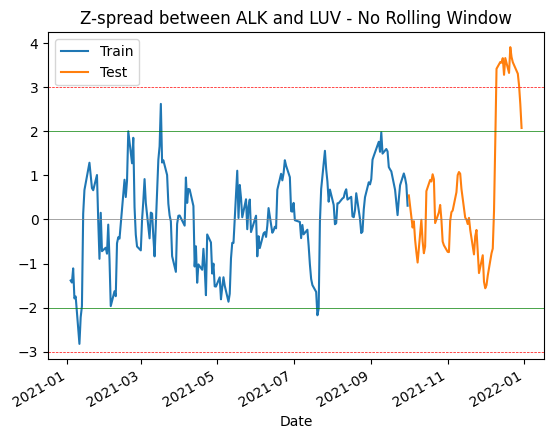

In [127]:
train_df.Z_Score.plot(label='Train')
test_df.Z_Score.plot(label='Test')
plt.axhline(0, c = 'gray', lw='0.5')
plt.axhline(-entry_point, c = 'g', lw='0.5')
plt.axhline(entry_point, c = 'g', lw='0.5')
plt.axhline(-stop_loss, c = 'r', lw='0.5', ls='--')
plt.axhline(stop_loss, c = 'r', lw='0.5', ls='--')
plt.title(f'Z-spread between {pair[0]} and {pair[1]} - No Rolling Window')
plt.legend();

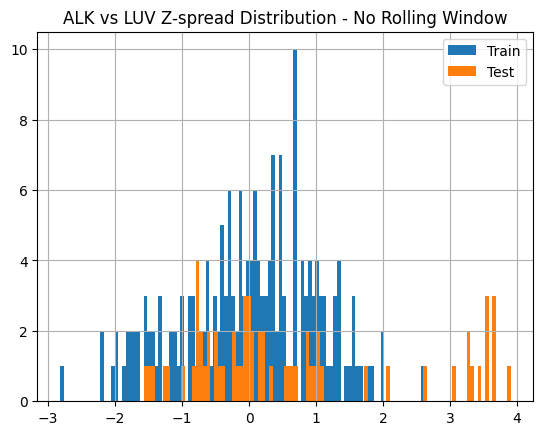

In [128]:
train_df.Z_Score.hist(bins= 100, label='Train')
test_df.Z_Score.hist(bins= 100, label='Test')
plt.title(f'{pair[0]} vs {pair[1]} Z-spread Distribution - No Rolling Window')
plt.legend()

#### 7.2 Trading Period - 20 Day Rolling Window

In [129]:
test_df_20d = trading_period(train_df,test_df,rolling_window=20)

In [130]:
entry_point = 2
stop_loss = 1.5 * entry_point
RR = entry_point/(stop_loss-entry_point)
print(f'Entry Point: {entry_point}, Stop Loss: {stop_loss} with a Risk/Reward Ratio of 1.0 : {RR}')

Entry Point: 2, Stop Loss: 3.0 with a Risk/Reward Ratio of 1.0 : 2.0


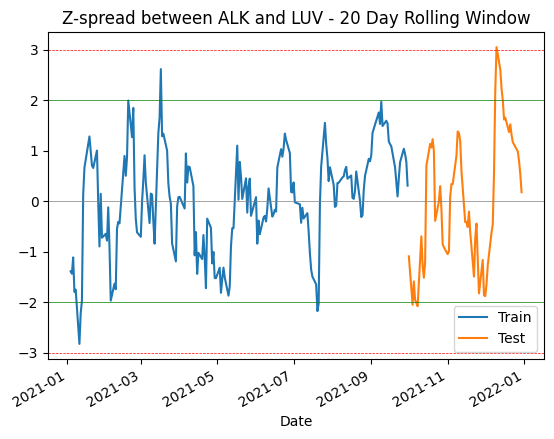

In [131]:
train_df.Z_Score.plot(label='Train')
test_df_20d.Z_Score.plot(label='Test')
plt.axhline(0, c = 'gray', lw='0.5')
plt.axhline(-entry_point, c = 'g', lw='0.5')
plt.axhline(entry_point, c = 'g', lw='0.5')
plt.axhline(-stop_loss, c = 'r', lw='0.5', ls='--')
plt.axhline(stop_loss, c = 'r', lw='0.5', ls='--')
plt.title(f'Z-spread between {pair[0]} and {pair[1]} - 20 Day Rolling Window')
plt.legend();

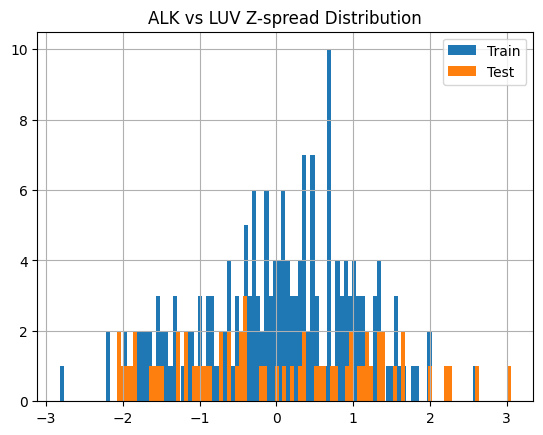

In [132]:
train_df.Z_Score.hist(bins= 100, label='Train')
test_df_20d.Z_Score.hist(bins= 100, label='Test')
plt.title(f'{pair[0]} vs {pair[1]} Z-spread Distribution')
plt.legend();

## 8. Strategy Execution and Backtesting

#### 8.1 Functions Definition

In [133]:
def strategy_execution(pairs_dataset, entry_point, stop_loss=None):
    
    dataset = pairs_dataset.copy()
    
    flag = 0
    trade_count = 0
    stop = 0
    
    dataset['trade_count'] = ''
    dataset['order'] = ''
    dataset[f'{pair[0]}_side'] = ''
    dataset[f'{pair[0]}_entry'] = ''
    dataset[f'{pair[0]}_price'] = ''
    dataset[f'{pair[1]}_side'] = ''
    dataset[f'{pair[1]}_entry'] = ''
    dataset[f'{pair[1]}_price'] = ''
    dataset[f'{pair[0]}_return'] = ''
    dataset[f'{pair[1]}_return'] = ''
    dataset[f'{pair[0]}_weight'] = ''
    dataset[f'{pair[1]}_weight'] = ''
    dataset['HR'] = ''
    dataset['total_return'] = 0
    
    for i in range(len(dataset)):
        
        if flag == 0:
            
            if stop == 1:
                
                if (dataset.Z_Score.iloc[i-1] <= entry_point) & (dataset.Z_Score.iloc[i-2] > entry_point):
                
                    dataset[f'{pair[0]}_side'].iloc[i] = -1
                    dataset[f'{pair[0]}_entry'].iloc[i] = dataset.iloc[:,0][i]
                    dataset[f'{pair[0]}_price'].iloc[i] = dataset.iloc[:,1][i]
                    dataset[f'{pair[1]}_side'].iloc[i] = 1
                    dataset[f'{pair[1]}_entry'].iloc[i] = dataset.iloc[:,2][i]
                    dataset[f'{pair[1]}_price'].iloc[i] = dataset.iloc[:,3][i]   

                    dataset[f'{pair[0]}_return'].iloc[i] = (dataset[f'{pair[0]}_price'].iloc[i] / dataset[f'{pair[0]}_entry'].iloc[i] - 1) * \
                    dataset[f'{pair[0]}_side'].iloc[i]
                    dataset[f'{pair[1]}_return'].iloc[i] = (dataset[f'{pair[1]}_price'].iloc[i] / dataset[f'{pair[1]}_entry'].iloc[i] - 1) * \
                    dataset[f'{pair[1]}_side'].iloc[i]              
                    dataset[f'{pair[0]}_weight'].iloc[i] = (1/(1 + dataset.Hedge_Ratio.iloc[i]))
                    dataset[f'{pair[1]}_weight'].iloc[i] = 1 - dataset[f'{pair[0]}_weight'].iloc[i]
                    dataset['HR'].iloc[i] = dataset.Hedge_Ratio.iloc[i]
                    dataset['total_return'].iloc[i] = dataset[f'{pair[0]}_weight'].iloc[i] * dataset[f'{pair[0]}_return'].iloc[i] + \
                    dataset[f'{pair[1]}_weight'].iloc[i] * dataset[f'{pair[1]}_return'].iloc[i]              
                    dataset['trade_count'].iloc[i] = trade_count = trade_count + 1
                    dataset['order'].iloc[i] = 'Open'
                    flag = -1
                    stop = 0
                    
                else:
                    dataset[f'{pair[0]}_side'].iloc[i] = 0
                    dataset[f'{pair[0]}_entry'].iloc[i] = ''
                    dataset[f'{pair[0]}_price'].iloc[i] = ''               
                    dataset[f'{pair[1]}_side'].iloc[i] = 0
                    dataset[f'{pair[1]}_entry'].iloc[i] = ''
                    dataset[f'{pair[1]}_price'].iloc[i] = '' 
                    dataset['trade_count'].iloc[i] = ''
            
            elif stop == -1:
                
                if (dataset.Z_Score.iloc[i-1] >= -entry_point) & (dataset.Z_Score.iloc[i-2] < -entry_point):
                    dataset[f'{pair[0]}_side'].iloc[i] = 1
                    dataset[f'{pair[0]}_entry'].iloc[i] = dataset.iloc[:,0][i]
                    dataset[f'{pair[0]}_price'].iloc[i] = dataset.iloc[:,1][i]
                    dataset[f'{pair[1]}_side'].iloc[i] = -1
                    dataset[f'{pair[1]}_entry'].iloc[i] = dataset.iloc[:,2][i]
                    dataset[f'{pair[1]}_price'].iloc[i] = dataset.iloc[:,3][i]

                    dataset[f'{pair[0]}_return'].iloc[i] = (dataset[f'{pair[0]}_price'].iloc[i] / dataset[f'{pair[0]}_entry'].iloc[i] - 1) * \
                    dataset[f'{pair[0]}_side'].iloc[i]
                    dataset[f'{pair[1]}_return'].iloc[i] = (dataset[f'{pair[1]}_price'].iloc[i] / dataset[f'{pair[1]}_entry'].iloc[i] - 1) * \
                    dataset[f'{pair[1]}_side'].iloc[i]             
                    dataset[f'{pair[0]}_weight'].iloc[i] = (1/(1 + dataset.Hedge_Ratio.iloc[i]))
                    dataset[f'{pair[1]}_weight'].iloc[i] = 1 - dataset[f'{pair[0]}_weight'].iloc[i]
                    dataset['HR'].iloc[i] = dataset.Hedge_Ratio.iloc[i]
                    dataset['total_return'].iloc[i] = dataset[f'{pair[0]}_weight'].iloc[i] * dataset[f'{pair[0]}_return'].iloc[i] + \
                    dataset[f'{pair[1]}_weight'].iloc[i] * dataset[f'{pair[1]}_return'].iloc[i]
                    dataset['trade_count'].iloc[i] = trade_count = trade_count + 1
                    dataset['order'].iloc[i] = 'Open'
                    flag = 1
                    stop = 0    

                else:
                    dataset[f'{pair[0]}_side'].iloc[i] = 0
                    dataset[f'{pair[0]}_entry'].iloc[i] = ''
                    dataset[f'{pair[0]}_price'].iloc[i] = ''               
                    dataset[f'{pair[1]}_side'].iloc[i] = 0
                    dataset[f'{pair[1]}_entry'].iloc[i] = ''
                    dataset[f'{pair[1]}_price'].iloc[i] = '' 
                    dataset['trade_count'].iloc[i] = ''                    
                    
            elif (dataset.Z_Score.iloc[i-1] <= -entry_point) & (dataset.Z_Score.iloc[i-2] > -entry_point):
                
                dataset[f'{pair[0]}_side'].iloc[i] = 1
                dataset[f'{pair[0]}_entry'].iloc[i] = dataset.iloc[:,0][i]
                dataset[f'{pair[0]}_price'].iloc[i] = dataset.iloc[:,1][i]
                dataset[f'{pair[1]}_side'].iloc[i] = -1
                dataset[f'{pair[1]}_entry'].iloc[i] = dataset.iloc[:,2][i]
                dataset[f'{pair[1]}_price'].iloc[i] = dataset.iloc[:,3][i]
                
                dataset[f'{pair[0]}_return'].iloc[i] = (dataset[f'{pair[0]}_price'].iloc[i] / dataset[f'{pair[0]}_entry'].iloc[i] - 1) * \
                dataset[f'{pair[0]}_side'].iloc[i]
                dataset[f'{pair[1]}_return'].iloc[i] = (dataset[f'{pair[1]}_price'].iloc[i] / dataset[f'{pair[1]}_entry'].iloc[i] - 1) * \
                dataset[f'{pair[1]}_side'].iloc[i]             
                dataset[f'{pair[0]}_weight'].iloc[i] = (1/(1 + dataset.Hedge_Ratio.iloc[i]))
                dataset[f'{pair[1]}_weight'].iloc[i] = 1 - dataset[f'{pair[0]}_weight'].iloc[i]
                dataset['HR'].iloc[i] = dataset.Hedge_Ratio.iloc[i]
                dataset['total_return'].iloc[i] = dataset[f'{pair[0]}_weight'].iloc[i] * dataset[f'{pair[0]}_return'].iloc[i] + \
                dataset[f'{pair[1]}_weight'].iloc[i] * dataset[f'{pair[1]}_return'].iloc[i]
                dataset['trade_count'].iloc[i] = trade_count = trade_count + 1
                dataset['order'].iloc[i] = 'Open'
                flag = 1

            elif (dataset.Z_Score.iloc[i-1] >= entry_point) & (dataset.Z_Score.iloc[i-2] < entry_point):
                
                dataset[f'{pair[0]}_side'].iloc[i] = -1
                dataset[f'{pair[0]}_entry'].iloc[i] = dataset.iloc[:,0][i]
                dataset[f'{pair[0]}_price'].iloc[i] = dataset.iloc[:,1][i]
                dataset[f'{pair[1]}_side'].iloc[i] = 1
                dataset[f'{pair[1]}_entry'].iloc[i] = dataset.iloc[:,2][i]
                dataset[f'{pair[1]}_price'].iloc[i] = dataset.iloc[:,3][i]   
                
                dataset[f'{pair[0]}_return'].iloc[i] = (dataset[f'{pair[0]}_price'].iloc[i] / dataset[f'{pair[0]}_entry'].iloc[i] - 1) * \
                dataset[f'{pair[0]}_side'].iloc[i]
                dataset[f'{pair[1]}_return'].iloc[i] = (dataset[f'{pair[1]}_price'].iloc[i] / dataset[f'{pair[1]}_entry'].iloc[i] - 1) * \
                dataset[f'{pair[1]}_side'].iloc[i]              
                dataset[f'{pair[0]}_weight'].iloc[i] = (1/(1 + dataset.Hedge_Ratio.iloc[i]))
                dataset[f'{pair[1]}_weight'].iloc[i] = 1 - dataset[f'{pair[0]}_weight'].iloc[i]
                dataset['HR'].iloc[i] = dataset.Hedge_Ratio.iloc[i]
                dataset['total_return'].iloc[i] = dataset[f'{pair[0]}_weight'].iloc[i] * dataset[f'{pair[0]}_return'].iloc[i] + \
                dataset[f'{pair[1]}_weight'].iloc[i] * dataset[f'{pair[1]}_return'].iloc[i]              
                dataset['trade_count'].iloc[i] = trade_count = trade_count + 1
                dataset['order'].iloc[i] = 'Open'
                flag = -1

            else:
                dataset[f'{pair[0]}_side'].iloc[i] = 0
                dataset[f'{pair[0]}_entry'].iloc[i] = ''
                dataset[f'{pair[0]}_price'].iloc[i] = ''               
                dataset[f'{pair[1]}_side'].iloc[i] = 0
                dataset[f'{pair[1]}_entry'].iloc[i] = ''
                dataset[f'{pair[1]}_price'].iloc[i] = '' 
                dataset['trade_count'].iloc[i] = ''
                
        elif flag == 1:
            
            if (dataset.Z_Score.iloc[i-1] >= 0) | (dataset.Z_Score.iloc[i-1] <= -stop_loss):
                dataset[f'{pair[0]}_side'].iloc[i] = dataset[f'{pair[0]}_side'].iloc[i-1]
                dataset[f'{pair[0]}_entry'].iloc[i] = dataset[f'{pair[0]}_entry'].iloc[i-1]
                dataset[f'{pair[0]}_price'].iloc[i] = dataset.iloc[:,0][i]                
                dataset[f'{pair[1]}_side'].iloc[i] = dataset[f'{pair[1]}_side'].iloc[i-1]
                dataset[f'{pair[1]}_entry'].iloc[i] = dataset[f'{pair[1]}_entry'].iloc[i-1]
                dataset[f'{pair[1]}_price'].iloc[i] = dataset.iloc[:,2][i]
                
                dataset[f'{pair[0]}_return'].iloc[i] = (dataset[f'{pair[0]}_price'].iloc[i] / dataset[f'{pair[0]}_price'].iloc[i-1] - 1) * \
                dataset[f'{pair[0]}_side'].iloc[i]
                dataset[f'{pair[1]}_return'].iloc[i] = (dataset[f'{pair[1]}_price'].iloc[i] / dataset[f'{pair[1]}_price'].iloc[i-1] - 1) * \
                dataset[f'{pair[1]}_side'].iloc[i]               
                dataset[f'{pair[0]}_weight'].iloc[i] = dataset[f'{pair[0]}_weight'].iloc[i-1]
                dataset[f'{pair[1]}_weight'].iloc[i] = dataset[f'{pair[1]}_weight'].iloc[i-1]
                dataset['HR'].iloc[i] = dataset['HR'].iloc[i-1]
                dataset['total_return'].iloc[i] = dataset[f'{pair[0]}_weight'].iloc[i] * dataset[f'{pair[0]}_return'].iloc[i] + \
                dataset[f'{pair[1]}_weight'].iloc[i] * dataset[f'{pair[1]}_return'].iloc[i]              
                dataset['trade_count'].iloc[i] = trade_count = trade_count + 1
                dataset['order'].iloc[i] = 'Close'
                flag = 0
                
                if dataset.Z_Score.iloc[i-1] <= -stop_loss:
                    stop = -1
                
            else:

                dataset[f'{pair[0]}_side'].iloc[i] = dataset[f'{pair[0]}_side'].iloc[i-1]
                dataset[f'{pair[0]}_entry'].iloc[i] = dataset[f'{pair[0]}_entry'].iloc[i-1]
                dataset[f'{pair[0]}_price'].iloc[i] = dataset.iloc[:,1][i]                
                dataset[f'{pair[1]}_side'].iloc[i] = dataset[f'{pair[1]}_side'].iloc[i-1]
                dataset[f'{pair[1]}_entry'].iloc[i] = dataset[f'{pair[1]}_entry'].iloc[i-1]
                dataset[f'{pair[1]}_price'].iloc[i] = dataset.iloc[:,3][i]       
                
                dataset[f'{pair[0]}_return'].iloc[i] = (dataset[f'{pair[0]}_price'].iloc[i] / dataset[f'{pair[0]}_price'].iloc[i-1] - 1) * \
                dataset[f'{pair[0]}_side'].iloc[i]
                dataset[f'{pair[1]}_return'].iloc[i] = (dataset[f'{pair[1]}_price'].iloc[i] / dataset[f'{pair[1]}_price'].iloc[i-1] - 1) * \
                dataset[f'{pair[1]}_side'].iloc[i]  
                dataset[f'{pair[0]}_weight'].iloc[i] = dataset[f'{pair[0]}_weight'].iloc[i-1]
                dataset[f'{pair[1]}_weight'].iloc[i] = dataset[f'{pair[1]}_weight'].iloc[i-1]
                dataset['HR'].iloc[i] = dataset['HR'].iloc[i-1]
                dataset['total_return'].iloc[i] = dataset[f'{pair[0]}_weight'].iloc[i] * dataset[f'{pair[0]}_return'].iloc[i] + \
                dataset[f'{pair[1]}_weight'].iloc[i] * dataset[f'{pair[1]}_return'].iloc[i]
                dataset['trade_count'].iloc[i] = ''
                
        elif flag == -1:
            
            if (dataset.Z_Score.iloc[i-1] <= 0) | (dataset.Z_Score.iloc[i-1] >= stop_loss):
                dataset[f'{pair[0]}_side'].iloc[i] = dataset[f'{pair[0]}_side'].iloc[i-1]
                dataset[f'{pair[0]}_entry'].iloc[i] = dataset[f'{pair[0]}_entry'].iloc[i-1]
                dataset[f'{pair[0]}_price'].iloc[i] = dataset.iloc[:,0][i]    
                dataset[f'{pair[1]}_side'].iloc[i] = dataset[f'{pair[1]}_side'].iloc[i-1]
                dataset[f'{pair[1]}_entry'].iloc[i] = dataset[f'{pair[1]}_entry'].iloc[i-1]
                dataset[f'{pair[1]}_price'].iloc[i] = dataset.iloc[:,2][i]
                
                dataset[f'{pair[0]}_return'].iloc[i] = (dataset[f'{pair[0]}_price'].iloc[i] / dataset[f'{pair[0]}_price'].iloc[i-1] - 1) * \
                dataset[f'{pair[0]}_side'].iloc[i]
                dataset[f'{pair[1]}_return'].iloc[i] = (dataset[f'{pair[1]}_price'].iloc[i] / dataset[f'{pair[1]}_price'].iloc[i-1] - 1) * \
                dataset[f'{pair[1]}_side'].iloc[i]             
                dataset[f'{pair[0]}_weight'].iloc[i] = dataset[f'{pair[0]}_weight'].iloc[i-1]
                dataset[f'{pair[1]}_weight'].iloc[i] = dataset[f'{pair[1]}_weight'].iloc[i-1]
                dataset['HR'].iloc[i] = dataset['HR'].iloc[i-1]
                dataset['total_return'].iloc[i] = dataset[f'{pair[0]}_weight'].iloc[i] * dataset[f'{pair[0]}_return'].iloc[i] + \
                dataset[f'{pair[1]}_weight'].iloc[i] * dataset[f'{pair[1]}_return'].iloc[i]            
                dataset['trade_count'].iloc[i] = trade_count = trade_count + 1
                dataset['order'].iloc[i] = 'Close'
                flag = 0
                
                if dataset.Z_Score.iloc[i-1] >= stop_loss:
                    stop = 1

            else:
                
                dataset[f'{pair[0]}_side'].iloc[i] = dataset[f'{pair[0]}_side'].iloc[i-1]
                dataset[f'{pair[0]}_entry'].iloc[i] = dataset[f'{pair[0]}_entry'].iloc[i-1]
                dataset[f'{pair[0]}_price'].iloc[i] = dataset.iloc[:,1][i]                
                dataset[f'{pair[1]}_side'].iloc[i] = dataset[f'{pair[1]}_side'].iloc[i-1]
                dataset[f'{pair[1]}_entry'].iloc[i] = dataset[f'{pair[1]}_entry'].iloc[i-1]
                dataset[f'{pair[1]}_price'].iloc[i] = dataset.iloc[:,3][i]  
                
                dataset[f'{pair[0]}_return'].iloc[i] = (dataset[f'{pair[0]}_price'].iloc[i] / dataset[f'{pair[0]}_price'].iloc[i-1] - 1) * \
                dataset[f'{pair[0]}_side'].iloc[i]
                dataset[f'{pair[1]}_return'].iloc[i] = (dataset[f'{pair[1]}_price'].iloc[i] / dataset[f'{pair[1]}_price'].iloc[i-1] - 1) * \
                dataset[f'{pair[1]}_side'].iloc[i]  
                dataset[f'{pair[0]}_weight'].iloc[i] = dataset[f'{pair[0]}_weight'].iloc[i-1]
                dataset[f'{pair[1]}_weight'].iloc[i] = dataset[f'{pair[1]}_weight'].iloc[i-1]
                dataset['HR'].iloc[i] = dataset['HR'].iloc[i-1]
                dataset['total_return'].iloc[i] = dataset[f'{pair[0]}_weight'].iloc[i] * dataset[f'{pair[0]}_return'].iloc[i] + \
                dataset[f'{pair[1]}_weight'].iloc[i] * dataset[f'{pair[1]}_return'].iloc[i]          
                dataset['trade_count'].iloc[i] = ''    
    
    dataset['Cum_Ret'] = ((1+dataset['total_return']).cumprod()-1)
    
    return dataset

In [134]:
def strategy_execution_chart(execution_train,execution_test,entry_point,stop_loss):

    open_trades_train = execution_train[execution_train.order == 'Open']
    close_trades_train = execution_train[execution_train.order == 'Close']
    open_trades_test = execution_test[execution_test.order == 'Open']
    close_trades_test = execution_test[execution_test.order == 'Close']

    plt.figure(figsize=(20,15))
    plt.subplot(3,1,1)
    execution_train.Z_Score.plot()
    execution_test.Z_Score.plot()
    plt.axhline(0, c = 'gray', lw='0.5')
    plt.axhline(-entry_point, c = 'g', lw='0.5')
    plt.axhline(entry_point, c = 'g', lw='0.5')
    plt.axhline(-stop_loss, c = 'r', lw='0.5', ls='--')
    plt.axhline(stop_loss, c = 'r', lw='0.5', ls='--')
    plt.title(f'Z-spread between {pair[0]} and {pair[1]}')

    plt.plot(open_trades_train[open_trades_train.iloc[:,8] == -1].Z_Score, 'v',markersize=10 ,color='g')
    plt.plot(open_trades_train[open_trades_train.iloc[:,8] == 1].Z_Score, '^',markersize=10 ,color='g')
    plt.plot(close_trades_train[close_trades_train.iloc[:,8] == 1].Z_Score, 'v',markersize=10 ,color='r')
    plt.plot(close_trades_train[close_trades_train.iloc[:,8] == -1].Z_Score, '^',markersize=10 ,color='r')

    plt.plot(open_trades_test[open_trades_test.iloc[:,8] == -1].Z_Score, 'v',markersize=10 ,color='g')
    plt.plot(open_trades_test[open_trades_test.iloc[:,8] == 1].Z_Score, '^',markersize=10 ,color='g')
    plt.plot(close_trades_test[close_trades_test.iloc[:,8] == 1].Z_Score, 'v',markersize=10 ,color='r')
    plt.plot(close_trades_test[close_trades_test.iloc[:,8] == -1].Z_Score, '^',markersize=10 ,color='r')

    plt.subplot(3,1,2)
    execution_train.iloc[:,8].plot()
    execution_test.iloc[:,8].plot()
    plt.axis(ymin=-1.2,ymax=1.2)

    plt.subplot(3,1,3)
    execution_train.Cum_Ret.plot()
    execution_test.Cum_Ret.plot()

    plt.legend()

    return plt.show()

#### 8.2 Strategy Execution 

In [135]:
execution_train = strategy_execution(train_df,entry_point,stop_loss)
execution_test = strategy_execution(test_df,entry_point,stop_loss)
execution_test_20d = strategy_execution(test_df_20d,entry_point,stop_loss)

#### 8.3 Strategy Backtesting

In [136]:
entry_point = 2
stop_loss = 1.5 * entry_point
RR = entry_point/(stop_loss-entry_point)
print(f'Entry Point: {entry_point}, Stop Loss: {stop_loss} with a Risk/Reward Ratio of 1.0 : {RR}')

Entry Point: 2, Stop Loss: 3.0 with a Risk/Reward Ratio of 1.0 : 2.0


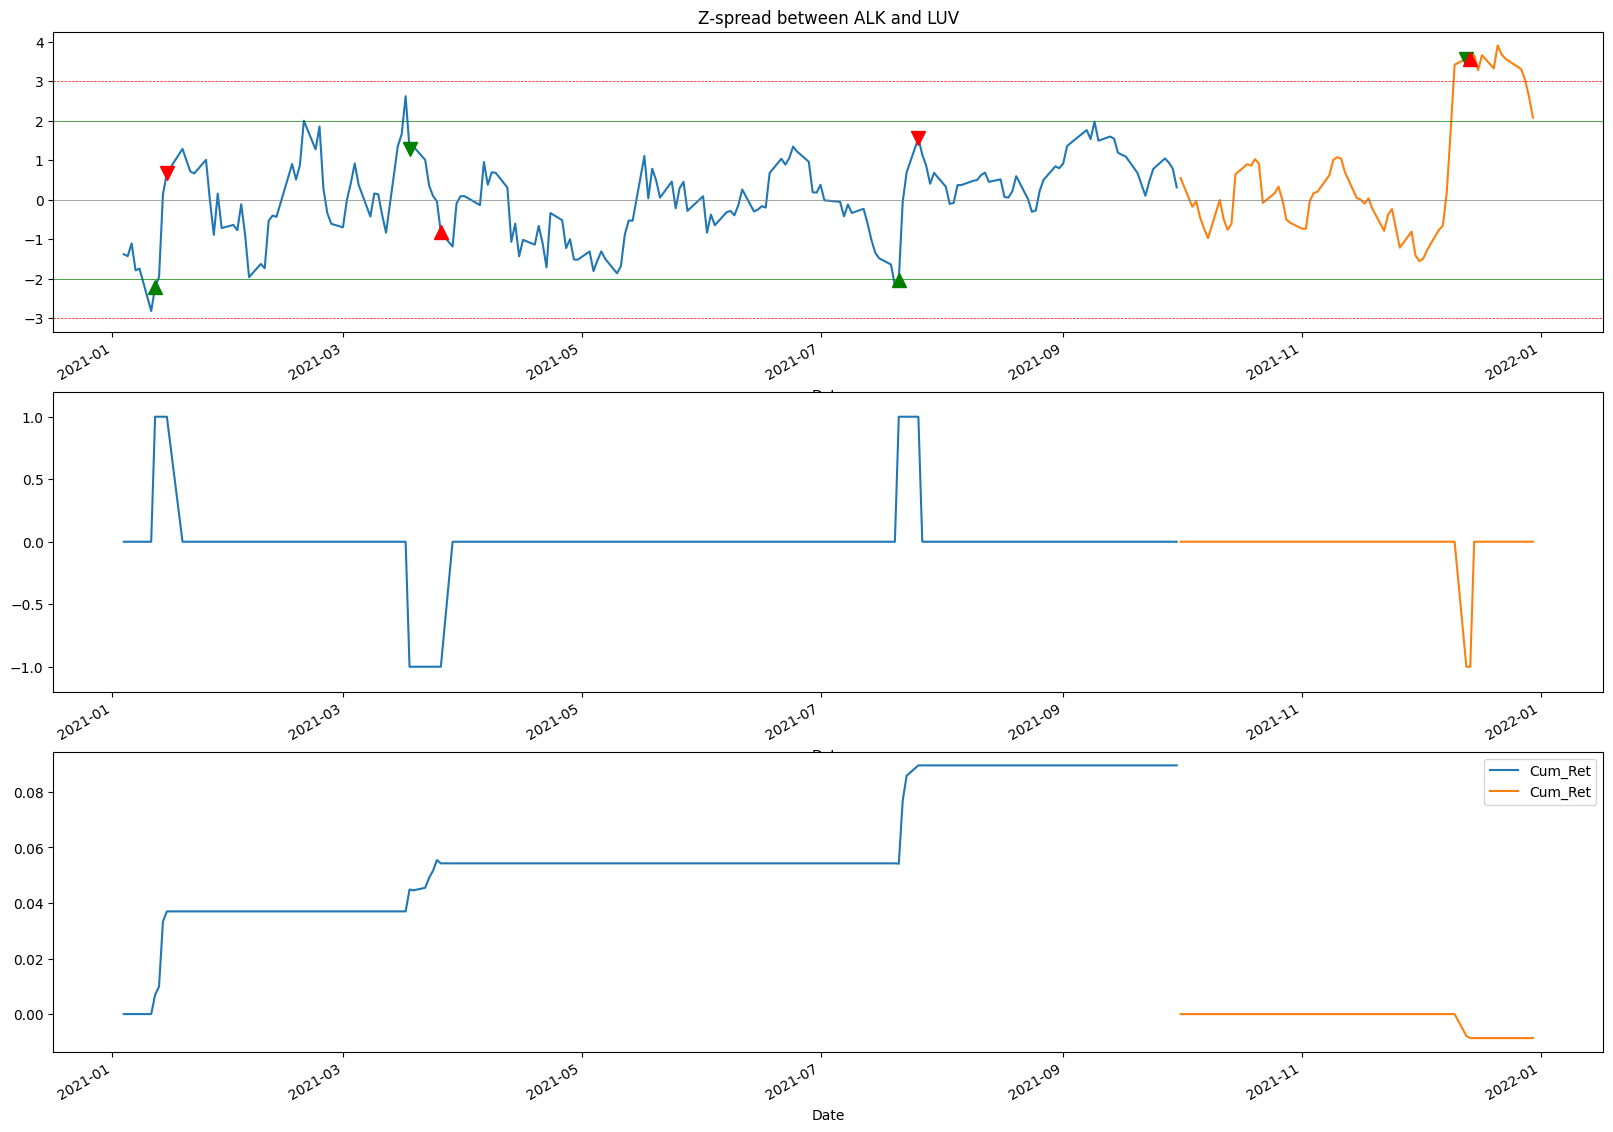

In [137]:
strategy_execution_chart(execution_train,execution_test,entry_point,stop_loss)

In [139]:
execution_train.Cum_Ret.iloc[-1], execution_test.Cum_Ret.iloc[-1]

(0.08953076993592779, -0.008639514590501829)

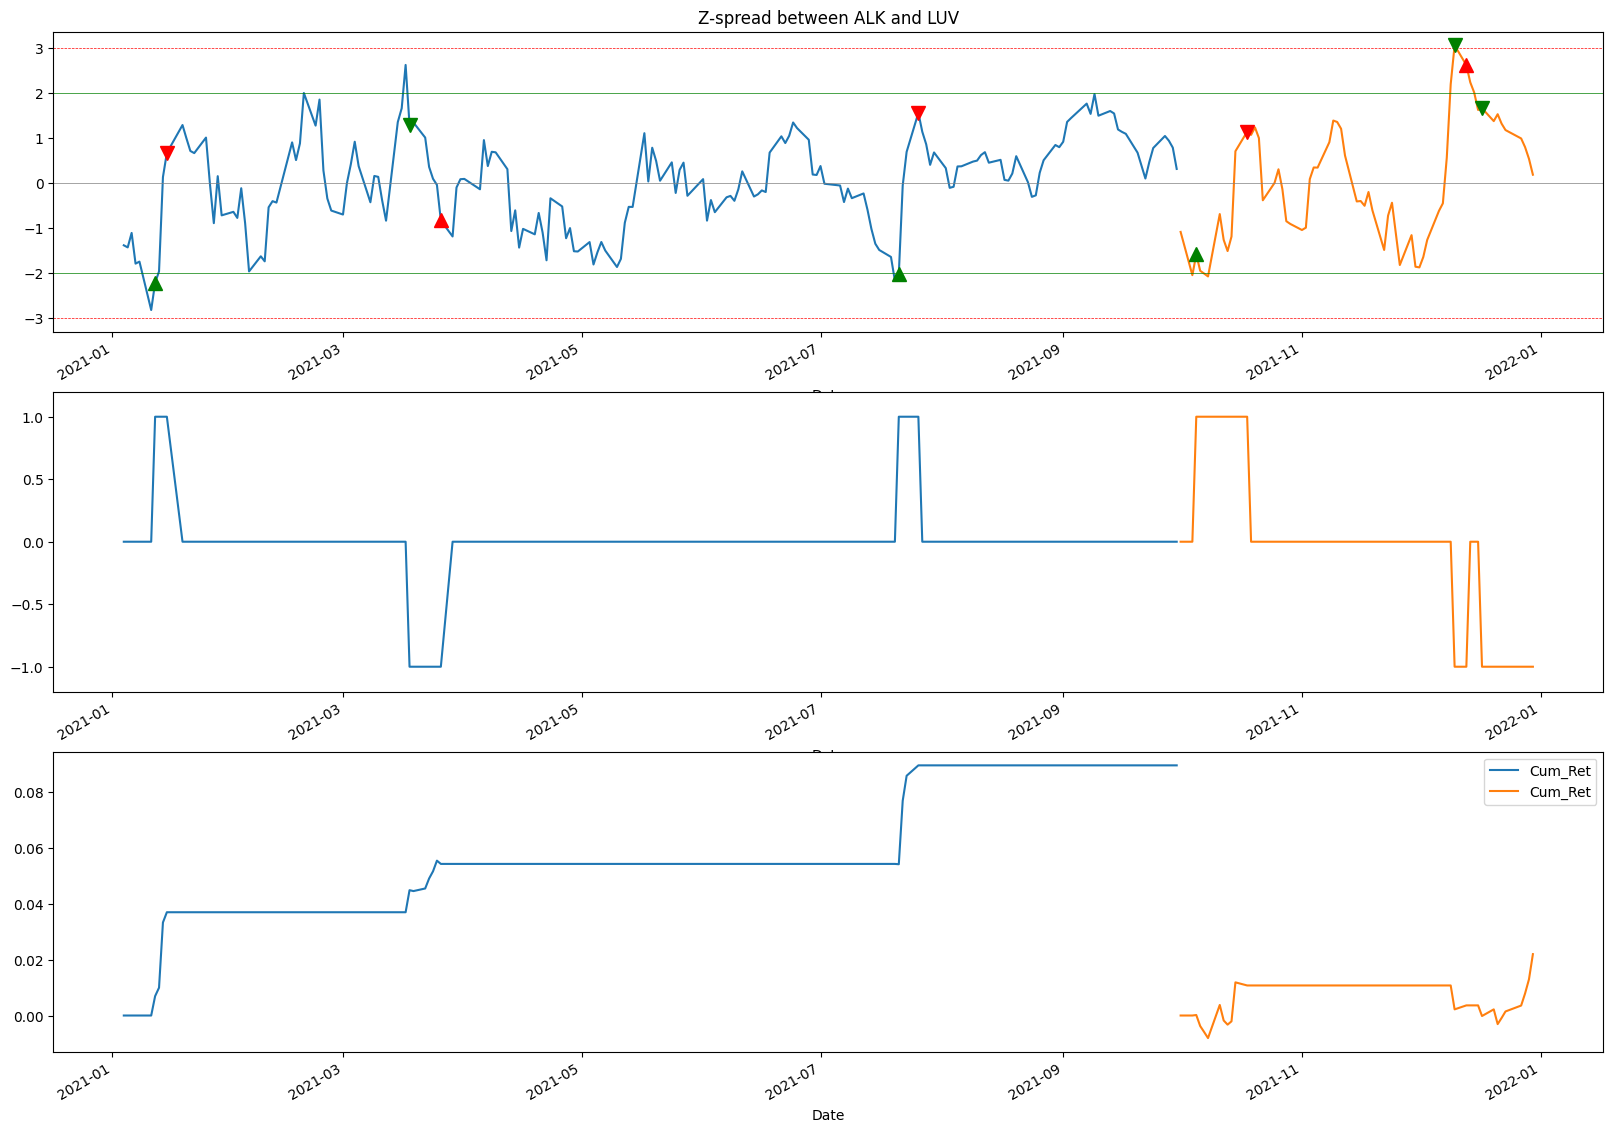

In [138]:
strategy_execution_chart(execution_train,execution_test_20d,entry_point,stop_loss)

In [140]:
execution_train.Cum_Ret.iloc[-1], execution_test_20d.Cum_Ret.iloc[-1]

(0.08953076993592779, 0.021969392109802532)

**Next Implementations**

- Model the Hedge Ratio using Kalman Filter
- Automate Entry Thrashold Definition
- Develop Trading performance Statistics
- Test if using chosing weighs according to Risk Parity instead of Hedge Ratio can improve Equity Line volatility
- Calculate the expected max profit of pair given the spread